## Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

### Инструкция по выполнению проекта
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.
* Загрузите и подготовьте данные.
* Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
* Проанализируйте скорость работы и качество моделей.

### Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

### Целевой признак
* Price — цена (евро)

## <a id="0.0"></a> Содержание

* [1. Загрузка и подготовка данных](#1.)
* [2. Обучение разных моделей](#2.)
    * [2.1 CatBoostRegressor](#2.1)
    * [2.2 LGBMRegressor](#2.2)
    * [2.3 LinearRegression](#2.3)
* [3. Анализ скорости работы и качества моделей](#3.)
* [4. Вывод](#4.)

## 1. Загрузка данных <a id="1."></a>
[к содержанию](#0.0)

In [2]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

Считаем данные и посмотрим общую информацию о датафрейме.

In [3]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# общая информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# размер
df.shape

(354369, 16)

In [6]:
# количество дубликатов
df.duplicated().sum()

4

Данные представлят таблицу с различными характеристиками автомобилей, размерностью 354369 на 16. Имеется 4 полных дубликата. В датасете также имеются признаки, напрямую не влияющие на стоимость автомобиля, такие как LastSeen, PostalCode, NumberOfPictures, DateCreated, DateCrawled. Удалим полные дубликаты а также ненужные для модели признаки

In [7]:
df = df.drop_duplicates()
df = df.drop(['LastSeen', 'PostalCode', 'NumberOfPictures', 'DateCreated', 'DateCrawled', 'RegistrationMonth'],axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Посмотрим статистику по признаку price.

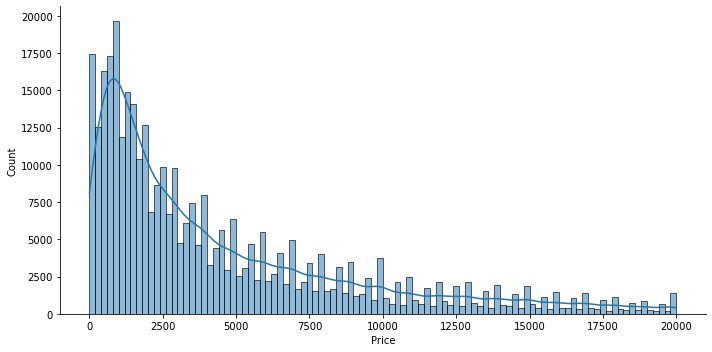

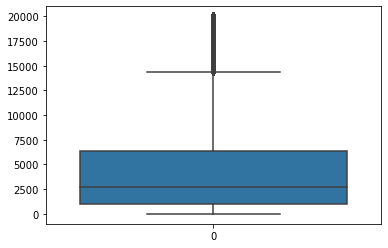

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [8]:
sns.displot(df['Price'],bins=100, kde=True, height=5, aspect=2)
plt.show()
sns.boxplot(data=df['Price'])
plt.show()
df['Price'].describe()

Как видим, есть нулевые знаения цены. Что может являться ошибкой данных, и может помешать обучению модели, так как цель моделирования - определение цены. Проверим долю записей с нулевыми значениями.

In [9]:
df[df['Price'] == 0].shape[0] / df.shape[0]

0.030398035923412302

Доля нулевых значений - 3%, удалим их из датасета.

In [10]:
df = df[df['Price'] != 0]

Посмотрим на статистику года регистрации авто

In [11]:
df['RegistrationYear'].describe()

count    343593.00000
mean       2004.08983
std          78.41368
min        1000.00000
25%        1999.00000
50%        2003.00000
75%        2008.00000
max        9999.00000
Name: RegistrationYear, dtype: float64

In [12]:
df[(df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > 2021)].shape[0]

139

Как видим, имеются записи, где год регистрации меньше 1900 и больше 2021, удалим эти записи

In [13]:
df = df[df['RegistrationYear'] > 1900]
df = df[df['RegistrationYear'] < 2021]

Проверим столбец с мощьностью двигателя

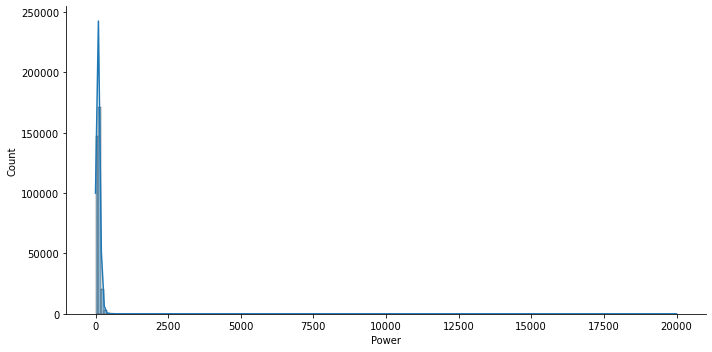

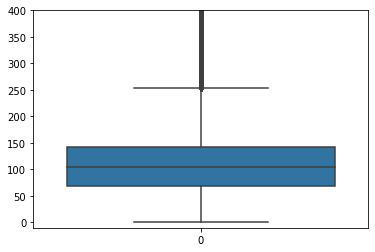

count    343454.000000
mean        110.981310
std         187.861108
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [14]:
sns.displot(df['Power'],bins=200, kde=True, height=5, aspect=2)
plt.show()
sns.boxplot(data=df['Power'])
plt.ylim(-10, 400)
plt.show()
df['Power'].describe()

Как видно, есть нулевые значения значения и аномальные значения выше 260 л.с. Посмотрим к-во таких значений

In [15]:
#к-во нулевых значений
df[df['Power'] == 0].shape[0]/df.shape[0]

0.10557163404706307

In [16]:
df[df['Power'] > 260].shape[0]/df.shape[0]

0.019036028114390865

Анамально-высокие значения можем удалить из выборки. А нулевых значений целых 10%, заменим их медианными значениями авто в зависимости от бренда, модели и типа топлива. 

In [17]:
df = df[df['Power'] <= 260]

In [18]:
# median = df.groupby(['Brand', 'Model', 'FuelType'])['Power'].transform('median')
# df['Power'] = df['Power'].fillna(median)

In [19]:
# сгруппируем данные по брэндам, моделям и типом топлива, также сделаем вторую группировку только по брэндам и моделям
df_for_median = df[['Brand', 'Model', 'FuelType']].dropna()
df_for_median = df.loc[df_for_median.index]
median1 = df_for_median.groupby(['Brand', 'Model', 'FuelType'])['Power'].median()
median1 = median1.reset_index()
median1 = median1.rename({'Power':'Median1'}, axis=1)

median2 = df_for_median.groupby(['Brand', 'Model'])['Power'].median()
median2 = median2.reset_index()
median2 = median2.rename({'Power':'Median2'}, axis=1)

df = df.merge(median1, how='left', on=['Brand','Model','FuelType'])
df = df.merge(median2, how='left', on=['Brand','Model'])

In [20]:
# функция для замены нулей и nan в Power
def power_nan(df):
    if df['Power'] == 0 or df['Power'] != df['Power']:
        if df['Median1'] != df['Median1']:
            return df['Median2']
        else:
            return df['Median1']
    else:
        return df['Power']
            
df["Power"] = df.apply(power_nan, axis=1)
df = df.drop(['Median1', 'Median2'], axis=1)

In [21]:
# удалим оставшиеся nan и нулевые значения в power 
df = df[~df["Power"].isnull()]
df = df[df['Power'] != 0]

Посмотрим значения пробега

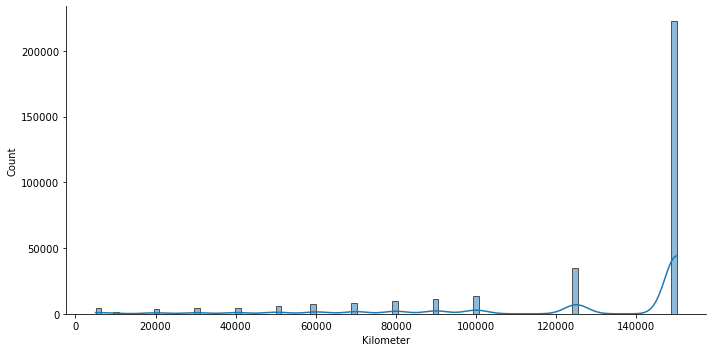

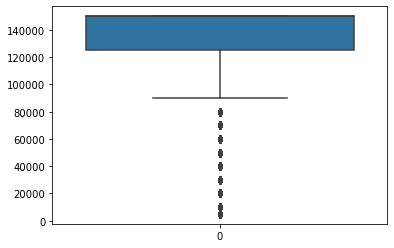

count    331852.000000
mean     128501.199330
std       37161.088502
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [22]:
sns.displot(df['Kilometer'],bins=100, kde=True, height=5, aspect=2)
plt.show()
sns.boxplot(data=df['Kilometer'])
plt.show()
df['Kilometer'].describe()

Видимо значения пробега упираются в потолок 150000, например, такое значение могло быть установлено как максимум при заполнений анкеты на сайте

Посмотрим количество пропусков

In [23]:
df.isna().sum()

Price                   0
VehicleType         30550
RegistrationYear        0
Gearbox             14896
Power                   0
Model               11965
Kilometer               0
FuelType            26491
Brand                   0
NotRepaired         61599
dtype: int64

Видим большое к-во пропусков, выделим пропуски в отдельную категорию 'unknown', чтобы не удалять такое большое к-во строк

In [24]:
df = df.fillna('unknown')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331852 entries, 0 to 336915
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             331852 non-null  int64  
 1   VehicleType       331852 non-null  object 
 2   RegistrationYear  331852 non-null  int64  
 3   Gearbox           331852 non-null  object 
 4   Power             331852 non-null  float64
 5   Model             331852 non-null  object 
 6   Kilometer         331852 non-null  int64  
 7   FuelType          331852 non-null  object 
 8   Brand             331852 non-null  object 
 9   NotRepaired       331852 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 37.9+ MB


Заменим тип данных в полях с типом object на тип category

In [26]:
categories_cols = df.select_dtypes(include='object').columns
for col in categories_cols:
    df[col] = df[col].astype('category')

Разделим данные на выборки

In [27]:
target = df['Price']
features = df.drop('Price', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              train_size=0.60, 
                                                                              test_size=0.40, 
                                                                              random_state=123)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            train_size=0.50, 
                                                                            test_size=0.50, 
                                                                            random_state=123)

In [28]:
features

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,unknown,1993,manual,90.0,golf,150000,petrol,volkswagen,unknown
1,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,yes
2,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
3,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...
336910,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes
336911,bus,2000,manual,125.0,zafira,150000,petrol,opel,no
336913,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
336914,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


## Вывод

В ходе предобработки были: 
* удалениы полные дубликаты, 
* признаки, не являющиеся характеристиками авто
* удалены аномальные значения года регистрации авто
* удалены аномально-высокие значения мощности двигателя, а нулевые значения и пропуски заменены медианными
* пропуски во всех категориальных полях заменены на "unknown"

    

## 2. Обучение разных моделей <a id="2."></a>

### 2.1 CatBoostRegressor <a id="2.1"></a>
[к содержанию](#0.0)

Обучим модель CatBoostRegressor и подберем оптимальные гиперпараметры

In [29]:
%%time
results = []
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired' ]
for iteration in range(10, 101, 20):
    for depth in range(5, 11, 2):
        model_cbr = CatBoostRegressor(loss_function = "RMSE",
                                      iterations = iteration,
                                      depth = depth,
                                      random_seed = 12345)
        model_cbr.fit(features_train, target_train, cat_features)



        start = time.time() 
        predictions_cbr = model_cbr.predict(features_valid, verbose=2)
        predict_time = time.time() - start
        mse = mean_squared_error(target_valid, predictions_cbr)
        RMSE = sqrt(mse)


        results.append({'Модель' : 'CatBoostRegressor',
                        'Итерации': iteration,
                        'Глубина': depth, 
                        'Скорость предсказания': predict_time, 
                        'RMSE': RMSE})
        


Learning rate set to 0.5
0:	learn: 3240.6587711	total: 110ms	remaining: 989ms
1:	learn: 2671.9763826	total: 158ms	remaining: 632ms
2:	learn: 2406.6208628	total: 237ms	remaining: 553ms
3:	learn: 2229.1932404	total: 286ms	remaining: 429ms
4:	learn: 2145.0142101	total: 323ms	remaining: 323ms
5:	learn: 2077.7687589	total: 361ms	remaining: 241ms
6:	learn: 2034.5262311	total: 397ms	remaining: 170ms
7:	learn: 2007.6970032	total: 431ms	remaining: 108ms
8:	learn: 1977.5812839	total: 489ms	remaining: 54.3ms
9:	learn: 1958.3986672	total: 544ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3115.7816166	total: 77.9ms	remaining: 701ms
1:	learn: 2508.0123541	total: 145ms	remaining: 582ms
2:	learn: 2219.6266538	total: 228ms	remaining: 531ms
3:	learn: 2101.5716129	total: 347ms	remaining: 520ms
4:	learn: 2003.9188201	total: 402ms	remaining: 402ms
5:	learn: 1955.9541922	total: 484ms	remaining: 323ms
6:	learn: 1922.8159331	total: 546ms	remaining: 234ms
7:	learn: 1898.5056353	total: 603ms	remaining: 15

In [30]:
cat_boost_results = pd.DataFrame.from_dict(results).sort_values(by='RMSE').reset_index(drop=True).head()
cat_boost_results

,Модель,Итерации,Глубина,Скорость предсказания,RMSE
0,CatBoostRegressor,90,9,0.087203,1621.777331
1,CatBoostRegressor,70,9,0.070144,1632.925822
2,CatBoostRegressor,50,9,0.070754,1652.996946
3,CatBoostRegressor,90,7,0.067494,1654.249771
4,CatBoostRegressor,70,7,0.064926,1667.986148


Построим график важности фичей для модели CatBoostRegressor

VehicleType: 10.047630282313305
RegistrationYear: 35.24929536051023
Gearbox: 1.5348093252783466
Power: 22.427997250775622
Model: 4.948038144029548
Kilometer: 9.929044739987237
FuelType: 2.7051277273556567
Brand: 9.811645293424837
NotRepaired: 3.3464118763251847


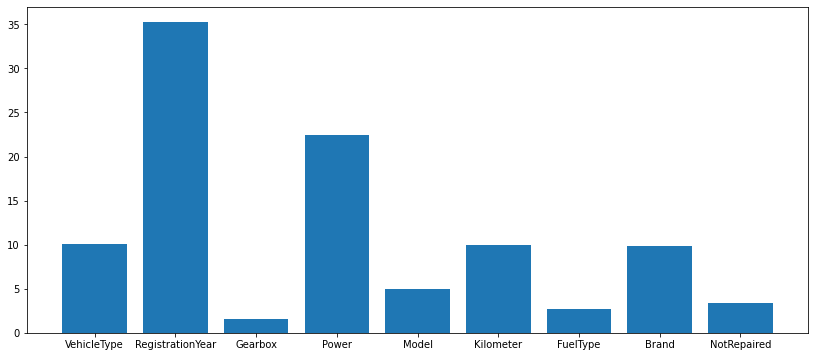

In [31]:
from matplotlib import pyplot
cbr_importance = model_cbr.get_feature_importance()


for i,v in enumerate(cbr_importance):
    print('{}: {}'.format(features.columns[i], v))
    
plt.figure(figsize=(14,6))
pyplot.bar([x for x in features.columns], cbr_importance)
pyplot.show()

Как видно, наиболее важными для модели оказались RegistrationYear и Power, наименее важными Gearbox и FuelType

### 2.2 LGBMRegressor <a id="2.2"></a>
[к содержанию](#0.0)

Обучим модель LGBMRegressor и подберем оптимальные гиперпараметры

In [32]:
%%time
results2 = []
for boosting_type in ['gbdt', 'dart', 'goss']:
    for n_estimators in range(10, 101, 20):
        model_lgbm = LGBMRegressor(boosting_type=boosting_type,
                                  n_estimators=n_estimators,
                                  random_seed = 12345)
        model_lgbm.fit(features_train, target_train) 
        start = time.time() 
        predictions_lgbm = model_lgbm.predict(features_valid, verbose=2)
        predict_time = time.time() - start
        
        mse = mean_squared_error(target_valid, predictions_lgbm)
        RMSE = sqrt(mse)
        
        results2.append({'Модель' : 'LGBMRegressor',
                        'Тип бустинга': boosting_type,
                        'n_estimators': n_estimators, 
                        'Скорость предсказания': predict_time, 
                        'RMSE': RMSE})
        


CPU times: user 1min 5s, sys: 2.38 s, total: 1min 8s
Wall time: 19 s


In [33]:
LGBM_results = pd.DataFrame.from_dict(results2).sort_values(by='RMSE').reset_index(drop=True).head()
LGBM_results

,Модель,Тип бустинга,n_estimators,Скорость предсказания,RMSE
0,LGBMRegressor,gbdt,90,0.201910,1630.453643
1,LGBMRegressor,goss,90,0.203960,1638.210717
2,LGBMRegressor,gbdt,70,0.165985,1645.528540
3,LGBMRegressor,goss,70,0.169568,1653.330286
4,LGBMRegressor,gbdt,50,0.134560,1678.473623


Построим график важности фичей для модели LGBMRegressor

VehicleType: 197
RegistrationYear: 601
Gearbox: 79
Power: 422
Model: 719
Kilometer: 264
FuelType: 73
Brand: 227
NotRepaired: 118


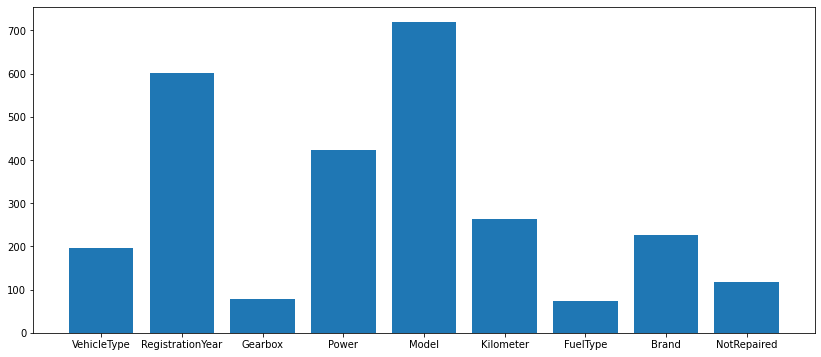

In [34]:
from matplotlib import pyplot
lgbm_importance = model_lgbm.feature_importances_


for i,v in enumerate(lgbm_importance):
    print('{}: {}'.format(features.columns[i], v))
    
plt.figure(figsize=(14,6))
pyplot.bar([x for x in features.columns], lgbm_importance)
pyplot.show()

Как видно, наиболее важными для модели оказались RegistrationYear и Model, наименее важными Gearbox и FuelType

### 2.3 LinearRegression <a id="2.3"></a>
[к содержанию](#0.0)

Преобразуем категориальные признаки методом get_dummies

In [35]:
df_lr = pd.get_dummies(df, drop_first=True)
df_lr.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,480,1993,90.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190.0,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69.0,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Разделим датафрейм на выборки

In [36]:
target_lr = df_lr['Price']
features_lr = df_lr.drop('Price', axis=1)

features_train_lr, features_valid_lr, target_train_lr, target_valid_lr = train_test_split(features_lr, 
                                                                              target_lr, 
                                                                              train_size=0.60, 
                                                                              test_size=0.40, 
                                                                              random_state=123)

features_valid_lr, features_test_lr, target_valid_lr, target_test_lr = train_test_split(features_valid_lr, 
                                                                            target_valid_lr, 
                                                                            train_size=0.50, 
                                                                            test_size=0.50, 
                                                                            random_state=123)

Обучим модель линейной регрессии

In [37]:
model_lr = LinearRegression()
model_lr.fit(features_train_lr, target_train_lr)


start = time.time() 
predictions_lr = model_lr.predict(features_valid_lr)
predict_time = time.time() - start

mse = mean_squared_error(target_valid_lr, predictions_lr)
RMSE = sqrt(mse)

results3 = []
results3.append({'Модель' : 'LinearRegression',
                'Скорость предсказания': predict_time, 
                'RMSE': RMSE})

In [38]:
LinearRegression_results = pd.DataFrame.from_dict(results3).sort_values(by='RMSE').reset_index(drop=True).head()
LinearRegression_results

,Модель,Скорость предсказания,RMSE
0,LinearRegression,0.122945,2581.108564


Сделаем второй вариант кодирования категорий через OrdinalEncoder

In [39]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [54]:
df_lr = df.copy()

In [58]:
# закодируем категориальные признаки 
categorical_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
df_lr[categorical_cols] = (
    enc.fit_transform(df_lr[categorical_cols])
)

In [62]:
df_lr.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,7.0,1993,1.0,90.0,116.0,150000,6.0,38.0,1.0
1,18300,2.0,2011,1.0,190.0,226.0,125000,2.0,1.0,2.0
2,9800,6.0,2004,0.0,163.0,117.0,125000,2.0,14.0,1.0
3,1500,5.0,2001,1.0,75.0,116.0,150000,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69.0,101.0,90000,2.0,31.0,0.0


In [63]:
# разделим на выборки
target_ord = df_lr['Price']
features_ord = df_lr.drop(['Price'],axis=1)
features_ord.columns = df.columns[1:]

Разделим датасет на выборки

In [64]:
target_ord = df['Price']

features_train_ord, features_valid_ord, target_train_ord, target_valid_ord = train_test_split(features_ord, 
                                                                              target_ord, 
                                                                              train_size=0.60, 
                                                                              test_size=0.40, 
                                                                              random_state=123)

features_valid_ord, features_test_ord, target_valid_ord, target_test_ord = train_test_split(features_valid_ord, 
                                                                            target_valid_ord, 
                                                                            train_size=0.50, 
                                                                            test_size=0.50, 
                                                                            random_state=123)

Обучим линейную регрессию

In [65]:
model_ord = LinearRegression()
model_ord.fit(features_train_ord, target_train_ord)


start = time.time() 
predictions_ord = model_ord.predict(features_valid_ord)
predict_time = time.time() - start

mse = mean_squared_error(target_valid_ord, predictions_ord)
RMSE = sqrt(mse)

results5 = []
results5.append({'Модель' : 'LinearRegression(OrdinalEncoding)',
                'Скорость предсказания': predict_time, 
                'RMSE': RMSE})

In [66]:
LinearRegression_OrdinalEncoding = pd.DataFrame.from_dict(results5).sort_values(by='RMSE').reset_index(drop=True).head()
LinearRegression_OrdinalEncoding

,Модель,Скорость предсказания,RMSE
0,LinearRegression(OrdinalEncoding),0.007055,2912.486728


Построим график важности факторов при моделировании линейной регрессией

VehicleType: -189.51330484854145
RegistrationYear: 139.98033947994355
Gearbox: -428.84926426838746
Power: 41.88766602306611
Model: -0.34253779660538747
Kilometer: -0.04474471586443459
FuelType: -447.8873029773413
Brand: 16.360699825642044
NotRepaired: -967.5431451162946


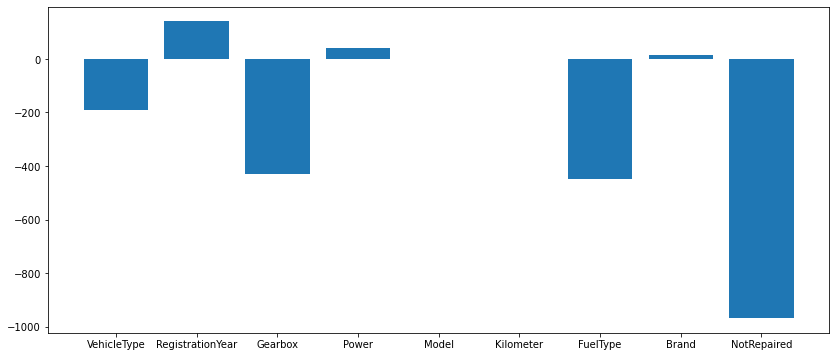

In [67]:
from matplotlib import pyplot
importance = model_ord.coef_


for i,v in enumerate(importance):
    print('{}: {}'.format(features_ord.columns[i], v))
    
plt.figure(figsize=(14,6))
pyplot.bar([x for x in features_ord.columns], importance)
pyplot.show()

Как видно, для модели наиболее важными стали признаки NotRepaired, FuelType, Gearbox. Наименее важными оказались Power, Model и Brand.

## 3. Анализ скорости работы и качества моделей <a id="3."></a>
[к содержанию](#0.0)

Сделаем проверку качества на адекватность, обучим "глупую" модель

In [202]:
dummy = DummyRegressor(strategy='mean')

dummy.fit(features_train, target_train)

start = time.time() 
predictions_dummy = dummy.predict(features_test)
predict_time = time.time() - start

mse = mean_squared_error(target_test, predictions_dummy)
RMSE = sqrt(mse)

results4 = []
results4.append({'Модель' : 'Dummy модель',
                'Скорость предсказания': predict_time, 
                'RMSE': RMSE})

DummyModel_results = pd.DataFrame.from_dict(results4)
DummyModel_results

,Модель,Скорость предсказания,RMSE
0,Dummy модель,0.002884,4415.145491


Внесем результаты работы моделей в таблицу

In [203]:
final_results = pd.concat([
    LGBM_results[['Модель', 'Скорость предсказания', 'RMSE']].head(1),
    cat_boost_results[['Модель', 'Скорость предсказания', 'RMSE']].head(1),
    LinearRegression_results,
    LinearRegression_OrdinalEncoding,
    DummyModel_results
])
final_results.sort_values(by='RMSE')

,Модель,Скорость предсказания,RMSE
0,CatBoostRegressor,0.070329,1621.777331
0,LGBMRegressor,0.208570,1630.453643
0,LinearRegression,0.123744,2581.108564
0,LinearRegression(OrdinalEncoding),0.003531,2979.564579
0,Dummy модель,0.002884,4415.145491


## Вывод <a id="4."></a>
[к содержанию](#0.0)

Получен сравнительный результат работы трех моделей CatBoostRegressor, LGBMRegressor и LinearRegression. Каждая модель отработала более качественно чем "глупая" модель, т.е. прошла проверку на адекватность. Наилучший результат по качеству и скорости показала модель CatBoostRegressor с результатом RMSE - 1621.8